In [27]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler

In [28]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv", "Fuzzy_dataset_SONATA")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,dt_d0,dt_d1,dt_d2,dt_d3,dt_d4,dt_d5,dt_d6,dt_d7,name,class,dataset,type,Label
0,0.369422,0.078324,0.000444,0.009978,0.724212,0.014852,0.008606,0.015570,0.009878,0.001069,0.011646,0.112122,0.257314,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.453125,0.025104,0.000232,0.009977,0.045600,0.019498,0.001095,0.011275,0.009880,0.009658,0.009361,0.009878,0.000904,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,0.343750,0.000896,0.000248,0.009981,0.009991,0.009826,0.000248,0.000808,0.001119,0.000480,0.001412,0.000899,0.000248,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,0.328125,0.008395,0.000234,0.009978,0.047617,0.038203,0.027087,0.009841,0.009859,0.009885,0.007653,0.000234,0.006513,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.375000,0.038187,0.000241,0.009978,0.036785,0.009870,0.000475,0.000475,0.034847,0.000475,0.000475,0.000241,0.000475,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135665,0.328125,0.078125,0.000242,0.008995,0.799798,0.001008,0.001246,0.000242,0.000242,0.149000,0.001974,0.159987,0.219917,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135666,0.187500,0.000000,0.002922,0.049999,0.013848,0.002922,0.002922,0.002922,0.002922,0.003930,0.004168,0.003930,0.003930,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135667,0.296875,0.015625,0.000468,0.009935,0.019970,0.009935,0.009935,0.009935,0.003868,0.009935,0.018993,0.009418,0.000468,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135668,0.312500,0.000000,0.000250,0.009935,0.009935,0.000718,0.005135,0.000718,0.000718,0.000718,0.000718,0.000718,0.000250,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0


In [29]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [30]:
# col = "dcs"
# v_r         = df.loc[(df["Label"] == 0) & (df["dataset"] == "ROAD"), col]
# v_sonata    = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Sonata"), col]
# v_soul      = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Soul"), col]
# v_spark     = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Spark"), col]

# print(v_r.mean(), v_r.std())
# print(v_sonata.mean(), v_sonata.std())
# print(v_soul.mean(), v_soul.std())
# print(v_spark.mean(), v_spark.std())

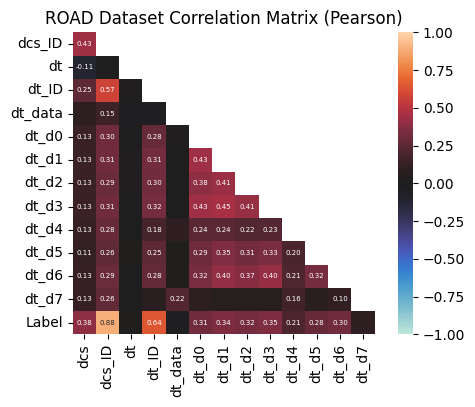

In [31]:
from plot_tools import plot_correlation_matrix

plot_correlation_matrix(df.drop(columns=["dataset", "type", "name", "class" "ID", "DLC", "t"], errors="ignore"))

In [32]:
from sklearn.preprocessing import StandardScaler, RobustScaler

feature_columns= list(set(df.columns.to_list()).difference(["name", "class", "dataset", "type", "Label"]))

for col in feature_columns:
    scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
    df.loc[:, df.columns == col] = scaler.transform(df.loc[:, df.columns == col])

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,dt_d0,dt_d1,dt_d2,dt_d3,dt_d4,dt_d5,dt_d6,dt_d7,name,class,dataset,type,Label
0,0.071447,0.802552,15.392904,-0.036750,0.866375,0.679258,0.752510,1.520016,0.739186,-0.745310,0.336812,12.294366,5.007122,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.666667,0.121326,-0.763636,-0.038113,0.007093,1.187873,-0.080271,1.073441,0.739357,0.103380,0.088818,1.009430,-0.016261,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,-0.111111,-0.188528,0.454545,-0.034453,-0.037996,0.129111,-0.174169,-0.014896,-0.183885,-0.803486,-0.773887,0.018311,-0.029114,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,-0.222222,-0.092542,-0.600000,-0.036783,0.009647,3.235510,2.801496,0.924378,0.737136,0.125780,-0.096581,-0.055051,0.093618,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.111111,0.288797,-0.090909,-0.036783,-0.004068,0.133925,-0.149005,-0.049479,3.370414,-0.803981,-0.875589,-0.054314,-0.024667,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135665,-0.222222,0.800000,0.000000,-0.848121,0.962084,-0.836248,-0.063519,-0.073699,-0.276325,13.871166,-0.712881,17.577432,4.274467,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135666,-1.222222,-0.200000,204.363636,32.986819,-0.033112,-0.626742,0.122281,0.204933,0.006080,-0.462615,-0.474797,0.352859,0.043019,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135667,-0.444444,0.000000,17.236364,-0.072595,-0.025360,0.140993,0.899818,0.934110,0.105776,0.130718,1.134192,0.958606,-0.024803,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
135668,-0.333333,-0.200000,0.618182,-0.072595,-0.038067,-0.867986,0.367661,-0.024194,-0.226150,-0.779953,-0.849195,-0.001632,-0.029072,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0


In [33]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [34]:
# X_train = df.loc[df["type"] != "normal"]
# y_train = X_train["Label"]
# X_train = X_train.drop(columns="Label")

# X_test = df.loc[df["type"] == "normal"]
# y_test = X_test["Label"]
# X_test = X_test.drop(columns="Label")

In [35]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		12682		5436
Attack		12682		5436


In [36]:
# train_index = X_train.loc[X_train["dataset"] == "Survival"].index
# test_index = X_test.loc[X_test["dataset"] == "ROAD"].index
# train_index = X_train.loc[(X_train["dataset"] == "Survival") & (X_train["name"] == "Fuzzy_dataset_SONATA")].index
# test_index = X_test.loc[(X_test["dataset"] == "ROAD") & (X_test["name"] == "fuzzing_attack_1")].index

# X_train = X_train.loc[train_index]
# y_train = y_train.loc[train_index]

# X_test = X_test.loc[test_index]
# y_test = y_test.loc[test_index]

In [37]:
name_train = X_train["name"]
# name_test = X_test["name"]
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2", warm_start=True)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', max_leaf_nodes=300, n_estimators=20,
                       random_state=0, warm_start=True)

In [39]:
# pred_train = clf.predict(X_train)
# clf.set_params(n_estimators=(20+13)) # Add another tree for the FN and FPs
# clf.fit(X_train.loc[y_train != pred_train], y_train.loc[y_train != pred_train])

In [40]:
scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

pred = clf.predict(X_test)

f1_scores = f1_score(y_test, pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1: 0.9991 (+/- 0.0005)
Testing F1:  0.9996(+/- 0.0000)
Kappa score:  0.9993(+/- 0.0000)


Plot train then test data predictions

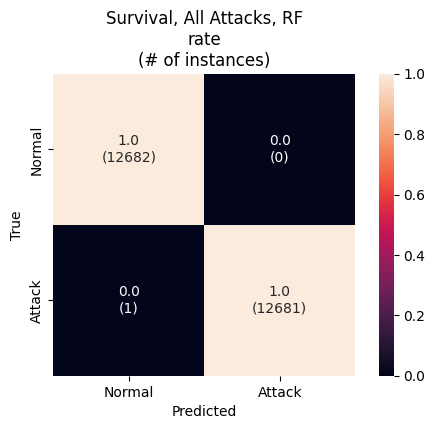

In [41]:
from plot_tools import plot_confusion_matrix

pred_train = clf.predict(X_train)

plot_confusion_matrix(y_train, pred_train, "Survival, All Attacks, RF\nrate\n(# of instances)")

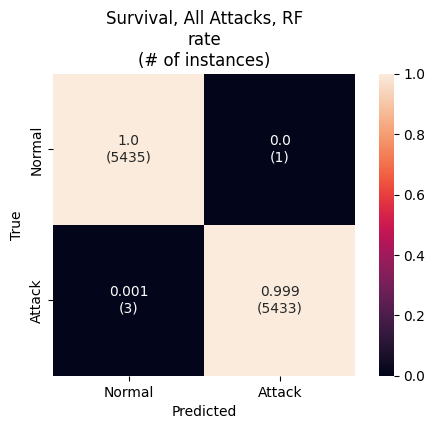

In [42]:
plot_confusion_matrix(y_test, pred, "Survival, All Attacks, RF\nrate\n(# of instances)")

In [45]:
import shap

exp = shap.TreeExplainer(clf, data=X_train, model_output="probability")

In [47]:
from shap_tools import *


# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
assert np.abs(exp.model.predict(X_train) - clf.predict_proba(X_train)).max() < 1e-4

shap_all = get_explanation(exp, X_train, 600)

# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs((shap_all.base_values + shap_all.values).sum(1) - clf.predict_proba(X_train)).max() < 1e-4

# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

# shap_TP_fuzz = get_explanation(exp, X_test.loc[(y_train == pred) & (pred == 1) & (name_test == "Fuzzy_dataset_SONATA")])

In [48]:
display(shap_all[:1,"dt_ID"])

.values =
array([-0.1732625])

.base_values =
array([0.5705])

.data =
array([-0.84477671])

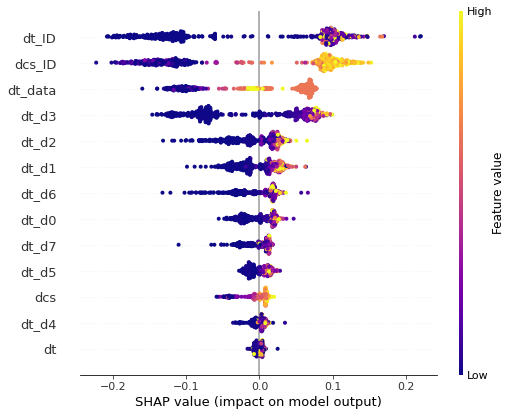

In [49]:
plot_beeswarm(shap_all)

In [20]:
# shap_TP_fuzz = get_explanation(exp, X_train.loc[(y_train == pred_train) & (pred_train == 1) & (name_train == "Fuzzy_dataset_SONATA")])
# plot_waterfall(shap_TP_fuzz, 0)

In [50]:
plot_force(shap_all)

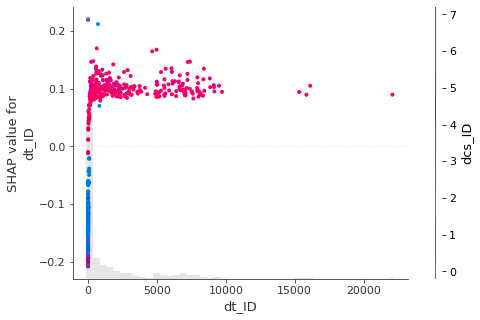

In [51]:
plot_scatter(shap_all, "dt_ID")

In [150]:
feature1 = "dcs_ID"
idx = shap_all.feature_names.index(feature1)
shap_sums = np.sum(shap_all.values, axis=1)
rule1 = X_train.sample(600, random_state=0)[(shap_sums > 0) & (shap_all.values[:,idx] > 0)][feature1].min()
rule1

0.359375

In [152]:
feature2 = "dt_ID"
idx = shap_all.feature_names.index(feature1)
shap_sums = np.sum(shap_all.values, axis=1)
rule2 = X_train.sample(600, random_state=0)[(shap_sums > 0) & (shap_all.values[:,idx] < 0)][feature1].max()
rule2 = 1

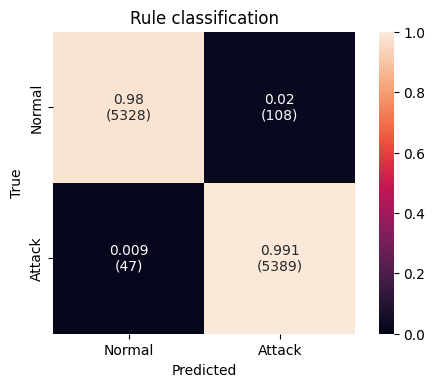

In [154]:
def rule_predictor(X: pd.DataFrame, y: pd.DataFrame):
    mask = (X[feature1] >= rule1) | (X[feature2] >= rule2)
    pred_out = y.copy() * 0
    pred_out.loc[mask] = 1
    # for i, row in X.iterrows():
    return pred_out

preddy = rule_predictor(X_test, y_test)

plot_confusion_matrix(y_test, preddy, "Rule classification")

# zeros = np.bincount(y_test.loc[mask])[0]
# ones = np.bincount(y_test.loc[mask])[1]
# # print(zeros)
# print(1 - zeros/ones)

In [22]:
# from sklearn.metrics import confusion_matrix
# pred_train = clf.predict(X_train)
# cm = confusion_matrix(y_train, pred_train)

# result = [[cm[0][1]], [cm[1][0]]]

# for i in range(1, 31):
#     clf.set_params(n_estimators=(20+i)) # Add another tree for the FN and FPs
#     clf.fit(X_train.loc[y_train != pred_train], y_train.loc[y_train != pred_train]) # 1 for FP, 0 for FN
#     pred_train = clf.predict(X_train)
#     cm = confusion_matrix(y_train, pred_train)
#     result[0].append(cm[0][1])
#     result[1].append(cm[1][0])

# print(result[0])
# print(result[1])

In [23]:
# plt.plot(result[0], label="FP")
# plt.plot(result[1], label="FN")
# plt.title("Change in FP and FN predictions\nwith more trees trained on FP and FN instances")
# plt.xlabel("Number of additional trees (originally 20)")
# plt.ylabel("Number of instances")
# plt.legend()
# plt.show